In [1]:
#!pip install pandas

In [2]:
import json
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import groupby
from anytree import PreOrderIter
from anytree.search import findall
from comorbid_graphs import ComorbidGraph, ComorbidGraphNode

In [3]:
with open('../tests/fixtures/symp_tree_labelled.json') as f:
    data = json.load(f)
cg = ComorbidGraph(data, node_type=ComorbidGraphNode, assign_ids=True, root_name='symptom-tree')

In [4]:
with open('../tests/fixtures/ND_tree.json') as f:
    data = json.load(f)
analysis_cg = ComorbidGraph(data, ComorbidGraphNode, assign_ids=True, root_name='nd-tree')
cg.process_graph([analysis_cg])


Extracting labels from 949 nodes.
Exctracted: 0
Exctracted: 100
Exctracted: 200
Exctracted: 300
Exctracted: 400
Exctracted: 500
Exctracted: 600
Exctracted: 700
Exctracted: 800
Exctracted: 900


In [5]:
result_cg = cg #.advanced_search('a inc_ancestor:symptom', ComorbidGraphNode)

In [6]:
def pivot_group(data_list, pivot='ancestor', attribute='name'):
    return {
        i:set([j[attribute] for j in gr])
        for i, gr in groupby(data_list, lambda x: x[pivot])
    }

In [7]:
#result_cg.get_nodes()

In [21]:
import pandas as pd
df = pd.DataFrame([
    {
        "node.id": i.id,
        "node":i.name,
        "labels": len(i.annotation_list),
        "body":i.body if i.body else '',
        **pivot_group(i.annotation_list, 'ancestor'),
        #**pivot_group(i.annotation_list, 'parent'),
    }
    for i in result_cg.get_nodes()
    if i.annotation_list != []
]).replace({np.nan: set()})
if len(df):
    df.set_index('node', inplace=True)
    display(df)

,node.id,labels,body,symptom-ontology,nd-tree
node,,,,,
urinary incontinence,255,3,Urinary incontinence is a urinary system sympt...,"{urinary incontinence, urinary system symptom}",{function}
urge incontinence,431,2,Urge incontinence is a urinary incontinence ch...,"{urge incontinence, urinary incontinence}",{}
stress incontinence,923,5,Stress incontinence is a urinary incontinence ...,"{stress incontinence, urinary incontinence, sn...",{PR_000000001}
oliguria,480,2,Oliguria is a urinary system symptom character...,"{urinary system symptom, oliguria}",{}
polyuria,500,2,Polyuria is a urinary system symptom character...,"{polyuria, urinary system symptom}",{}
...,...,...,...,...,...
hypermenorrhea,770,4,Hypermenorrhea is a menorrhagia characterized ...,"{hypermenorrhea, menorrhagia}",{PR_000000001}
vaginismus,687,3,Vaginismus is a reproductive system symptom ch...,"{reproductive system symptom, vaginismus}",{pain}
premature labor,689,3,Premature labor is a reproductive system sympt...,"{reproductive system symptom, premature labor}",{PR_000000001}


In [22]:
def intersect_series(series):
    cleaned = [i for i in series if i is not None]
    if cleaned == []:
        return []
    return set.intersection(*cleaned)

def union_series(series):
    cleaned = [i for i in series if i is not None]
    if cleaned == []:
        return []
    return set.union(*cleaned)
df['all'] = df.iloc[:,3:].apply(union_series, axis=1)
df['common'] = df.iloc[:,3:-1].apply(intersect_series, axis=1)
shared = {}
for name, values in df.iloc[:,3:-1].iteritems():
    shared[name] = union_series(values)
shared['node'] = 'total'
df = df.append(pd.DataFrame([shared]).set_index('node'))

df

,node.id,labels,body,symptom-ontology,nd-tree,all,common
node,,,,,,,
urinary incontinence,255,3.0,Urinary incontinence is a urinary system sympt...,"{urinary incontinence, urinary system symptom}",{function},"{function, urinary incontinence, urinary syste...",{}
urge incontinence,431,2.0,Urge incontinence is a urinary incontinence ch...,"{urge incontinence, urinary incontinence}",{},"{urge incontinence, urinary incontinence}",{}
stress incontinence,923,5.0,Stress incontinence is a urinary incontinence ...,"{stress incontinence, urinary incontinence, sn...",{PR_000000001},"{stress incontinence, sneezing, urinary incont...",{}
oliguria,480,2.0,Oliguria is a urinary system symptom character...,"{urinary system symptom, oliguria}",{},"{urinary system symptom, oliguria}",{}
polyuria,500,2.0,Polyuria is a urinary system symptom character...,"{polyuria, urinary system symptom}",{},"{polyuria, urinary system symptom}",{}
...,...,...,...,...,...,...,...
vaginismus,687,3.0,Vaginismus is a reproductive system symptom ch...,"{reproductive system symptom, vaginismus}",{pain},"{reproductive system symptom, pain, vaginismus}",{}
premature labor,689,3.0,Premature labor is a reproductive system sympt...,"{reproductive system symptom, premature labor}",{PR_000000001},"{reproductive system symptom, premature labor,...",{}
infertility,685,3.0,Infertility is a reproductive system symptom c...,"{infertility, reproductive system symptom}",{PR_000000001},"{infertility, reproductive system symptom, PR_...",{}


<AxesSubplot:xlabel='node'>

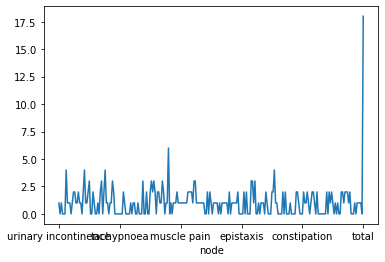

In [23]:
df.iloc[:, 3:]['nd-tree'].apply(len).groupby().plot()